# BA820 Milestone 2: Affordability Profile Segmentation Analysis

**Student:** Aryan Jain  
**Team:** A1-13   
**Course:** BA820 - Unsupervised and Unstructured Machine Learning  
**GitHub:** https://github.com/aryann25-cmd/BA820-Childcare-Programming-Analysis

---

## Research Question (from M1 Proposal)

*Can counties be segmented into distinct affordability profiles based on the joint distribution of childcare burden relative to income and female labor force participation rates, revealing whether high-participation counties maintain affordability through different mechanisms compared to low-participation counties?*



---

### Breaking Down the Question for M2

To thoroughly investigate this question, I decompose it into three sub-questions:

#### Sub-Question 1: Burden-Income Profiles
**What affordability profiles emerge when clustering on burden-income relationships?**
#### Sub-Question 2: Participation Patterns
**What participation patterns exist across counties?**
#### Sub-Question 3: Mechanism Integration
**Do burden-income profiles align with participation patterns, or do they reveal
independent mechanisms?**

---
## M2 Focus: Exploration & Learning

This milestone demonstrates my individual analytical exploration for M2. The goal is NOT to produce a perfect final solution, but to:

-  **Explore** the data using unsupervised methods
-  **Document** what works and what doesn't
-  **Reflect** on how my understanding evolved
-  **Learn** from failures and surprises

**Two Methods Applied:**
1. **PCA** - Understanding dimensionality and variable relationships
2. **K-means Clustering** - Segmenting counties into affordability profiles

---

## Key Philosophy

> "M2 is about showing that you can interrogate data and articulate what you learned — including what did NOT work."

This notebook documents my learning journey, failures, and refined thinking.

---

# SECTION 1: Environment Setup & Library Imports

Importing necessary libraries for data manipulation, visualization, dimensionality reduction, and clustering.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import f_oneway
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")



---

# SECTION 2: Data Loading

Loading the childcare costs dataset and examining its basic structure.

**Data Source:** TidyTuesday - National Database of Childcare Prices  
**Coverage:** County-level data from 2008-2018

In [12]:
df = pd.read_csv("childcare_costs.csv")
print(f"Dataset: {len(df):,} observations, {df['study_year'].min()}-{df['study_year'].max()}")
print(f"Counties: {df['county_fips_code'].nunique():,}")

Dataset: 34,567 observations, 2008-2018
Counties: 3,144


---

# SECTION 3: Feature Engineering

**Research Question Focus:** The question asks about "joint distribution" of childcare burden, income, and labor participation.

**Key Decisions:**

1. **Which year?** Using 2018 (best data completeness from M1)
2. **How to measure burden?** Create `burden_pct = (cost / weekly_income) × 100`
3. **Which variables?** Focus on 3 core variables:
   - `burden_pct` - Affordability burden
   - `flfpr_20to64` - Female labor force participation
   - `mhi_2018` - Median household income

4. **Outlier handling?** Remove extreme values (burden >50%, likely data errors)

In [13]:
df_2018 = df[df['study_year'] == 2018].copy()
df_2018['weekly_income'] = df_2018['mhi_2018'] / 52
df_2018['burden_pct'] = (df_2018['mcsa'] / df_2018['weekly_income']) * 100

key_vars = ['burden_pct', 'flfpr_20to64', 'mhi_2018']
df_clean = df_2018[key_vars].dropna()
df_clean = df_clean[df_clean['burden_pct'] <= 50]

print(f"Clean dataset: {len(df_clean):,} counties")
print(f"\nVariable Summary:")
print(df_clean.describe().round(2))

Clean dataset: 2,360 counties

Variable Summary:
       burden_pct  flfpr_20to64   mhi_2018
count     2360.00       2360.00    2360.00
mean        11.43         69.60   52184.90
std          3.36          7.85   14026.09
min          2.17         35.90   20188.00
25%          9.20         64.50   42946.25
50%         11.44         70.15   50341.50
75%         13.73         75.30   58135.00
max         31.56         92.20  136268.00



## Data Quality & Preprocessing Checks

Before clustering, we must ensure data quality and appropriate transformations.

### Missing Data Analysis

**Question:** Do we have complete data for the three key variables?

In [26]:
# Missing data check
print("Missing Data Analysis:")
print(f"  burden_pct:    {df_clean['burden_pct'].isna().sum()} missing ({df_clean['burden_pct'].isna().mean()*100:.2f}%)")
print(f"  flfpr_20to64:  {df_clean['flfpr_20to64'].isna().sum()} missing ({df_clean['flfpr_20to64'].isna().mean()*100:.2f}%)")
print(f"  mhi_2018:      {df_clean['mhi_2018'].isna().sum()} missing ({df_clean['mhi_2018'].isna().mean()*100:.2f}%)")
print(f"\nTotal counties with complete data: {len(df_clean):,}")

Missing Data Analysis:
  burden_pct:    0 missing (0.00%)
  flfpr_20to64:  0 missing (0.00%)
  mhi_2018:      0 missing (0.00%)

Total counties with complete data: 2,360


### Distribution Analysis

**Question:** Are variables heavily skewed? Do we need transformations?

Skewness Analysis:
  burden_pct:    0.249
  flfpr_20to64:  -0.474
  mhi_2018:      1.339

Interpretation:
  Skewness < 0.5: Approximately symmetric
  Skewness 0.5-1: Moderately skewed
  Skewness > 1:   Highly skewed (log transform may help)


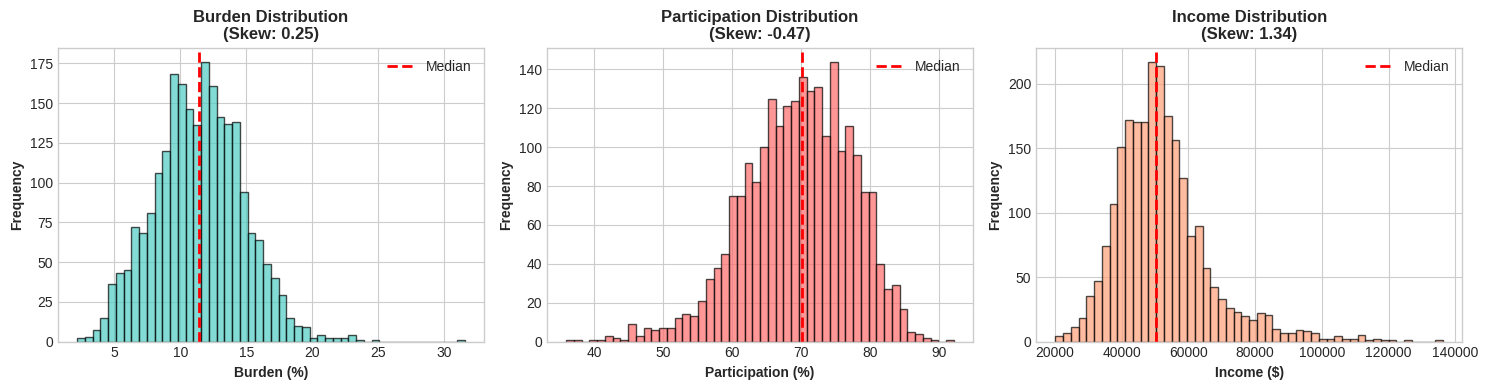

In [27]:
# Check skewness
print("Skewness Analysis:")
print(f"  burden_pct:    {df_clean['burden_pct'].skew():.3f}")
print(f"  flfpr_20to64:  {df_clean['flfpr_20to64'].skew():.3f}")
print(f"  mhi_2018:      {df_clean['mhi_2018'].skew():.3f}")

print("\nInterpretation:")
print("  Skewness < 0.5: Approximately symmetric")
print("  Skewness 0.5-1: Moderately skewed")
print("  Skewness > 1:   Highly skewed (log transform may help)")

# Visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df_clean['burden_pct'], bins=50, edgecolor='black', alpha=0.7, color='#4ECDC4')
axes[0].set_xlabel('Burden (%)', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title(f'Burden Distribution\n(Skew: {df_clean["burden_pct"].skew():.2f})', fontweight='bold')
axes[0].axvline(df_clean['burden_pct'].median(), color='red', linestyle='--', linewidth=2, label='Median')
axes[0].legend()

axes[1].hist(df_clean['flfpr_20to64'], bins=50, edgecolor='black', alpha=0.7, color='#FF6B6B')
axes[1].set_xlabel('Participation (%)', fontweight='bold')
axes[1].set_ylabel('Frequency', fontweight='bold')
axes[1].set_title(f'Participation Distribution\n(Skew: {df_clean["flfpr_20to64"].skew():.2f})', fontweight='bold')
axes[1].axvline(df_clean['flfpr_20to64'].median(), color='red', linestyle='--', linewidth=2, label='Median')
axes[1].legend()

axes[2].hist(df_clean['mhi_2018'], bins=50, edgecolor='black', alpha=0.7, color='#FFA07A')
axes[2].set_xlabel('Income ($)', fontweight='bold')
axes[2].set_ylabel('Frequency', fontweight='bold')
axes[2].set_title(f'Income Distribution\n(Skew: {df_clean["mhi_2018"].skew():.2f})', fontweight='bold')
axes[2].axvline(df_clean['mhi_2018'].median(), color='red', linestyle='--', linewidth=2, label='Median')
axes[2].legend()

plt.tight_layout()
plt.savefig('00_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

---

# SECTION 4: Exploratory Data Analysis

**Goal:** Visualize relationships between burden, participation, and income to understand if natural groupings exist.

**Questions to explore:**
- Do burden and participation correlate?
- Does the "affordability paradox" from M1 hold? (low income -> high burden)
- Are there visible clusters or is structure hidden?

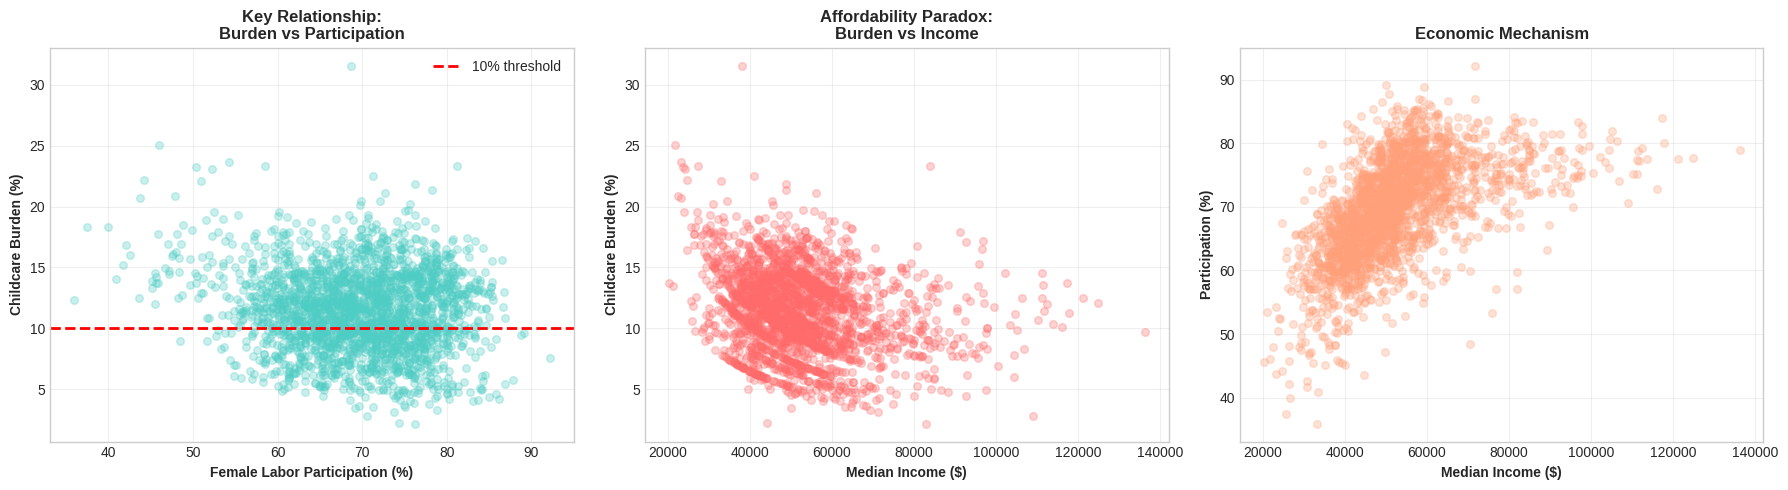

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(df_clean['flfpr_20to64'], df_clean['burden_pct'],
                alpha=0.3, s=30, color='#4ECDC4')
axes[0].axhline(y=10, color='red', linestyle='--', linewidth=2, label='10% threshold')
axes[0].set_xlabel('Female Labor Participation (%)', fontweight='bold')
axes[0].set_ylabel('Childcare Burden (%)', fontweight='bold')
axes[0].set_title('Key Relationship:\nBurden vs Participation', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(df_clean['mhi_2018'], df_clean['burden_pct'],
                alpha=0.3, s=30, color='#FF6B6B')
axes[1].set_xlabel('Median Income ($)', fontweight='bold')
axes[1].set_ylabel('Childcare Burden (%)', fontweight='bold')
axes[1].set_title('Affordability Paradox:\nBurden vs Income', fontweight='bold')
axes[1].grid(True, alpha=0.3)

axes[2].scatter(df_clean['mhi_2018'], df_clean['flfpr_20to64'],
                alpha=0.3, s=30, color='#FFA07A')
axes[2].set_xlabel('Median Income ($)', fontweight='bold')
axes[2].set_ylabel('Participation (%)', fontweight='bold')
axes[2].set_title('Economic Mechanism', fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('01_exploration.png', dpi=300, bbox_inches='tight')
plt.show()

##  Interpretation: What Do These Relationships Reveal?

### Plot 1: Burden vs Participation (Key Relationship for Research Question)

**Observation:**
- Wide vertical spread at all participation levels (50-90%)
- Counties with 60-70% participation show burden ranging from 5% to 30%
- NO clear linear relationship - weak/no correlation
- Most counties cluster between 5-15% burden, but substantial variation exists

**What This Means:**
- High labor participation does NOT automatically mean low burden
- The relationship is more complex than "more workers -  more affordable"
- **Implication:** Other factors (income, local markets) interact with participation to determine burden


**Why This Motivates Clustering:**
At the same participation level (~65%), some counties have 7% burden while others have 18%. These likely represent **different affordability mechanisms** that simple correlations won't reveal.


### Plot 2: Burden vs Income (Affordability Paradox)

**Observation:**
- Clear inverse relationship: as income increases, burden decreases
- Strong negative correlation (downward trend visible)
- At $40k income: burden ranges 10-25%
- At $100k income: burden ranges 3-10%
- **Confirms M1 "affordability paradox"**: Lower income → higher relative burden despite lower absolute costs

**What This Means:**
- Income is a KEY driver of affordability burden
- BUT: At same income level, burden still varies widely (e.g., $60k → 6-15% burden)
- Relationship is not deterministic - other factors moderate this effect

**Why This Motivates Clustering:**
Counties with identical incomes ($60k) show 2-3x difference in burden. What explains this variation? Likely local market conditions, childcare supply, or participation patterns - exactly what clustering can reveal.


### Plot 3: Participation vs Income (Economic Mechanism)

**Observation:**
- Positive relationship: higher income → higher participation (upward trend)
- Strong clustering in the 55-75% participation range
- Participation "ceiling" around 85-90% regardless of income
- Wide income spread at similar participation levels

**What This Means:**
- Income enables (or necessitates) labor force participation
- But participation plateaus - even very high-

---

# METHOD 1: Principal Component Analysis (PCA)

## Motivation

The research question mentions "joint distribution" of 3 variables (burden, participation, income). But:

**Key Question:** Are all 3 dimensions necessary, or is there redundancy?

**Approach:** Use PCA to:
1. Understand how much variance each dimension contributes
2. Determine if dimensionality reduction is appropriate
3. Interpret what the principal components represent

**Why This Matters:**
- If PC1+PC2 capture >90% variance -> could cluster in lower dimensions
- If variance is distributed -> need all 3 dimensions
- Loadings reveal which variables drive affordability structure


 Features standardized (mean=0, std=1)

 PCA Results:
   PC1:  55.3% variance
   PC2:  30.5% variance
   PC3:  14.3% variance

   PC1+PC2:  85.7% cumulative
   All PCs:  100.0% cumulative

 Feature Loadings (What do PCs represent?):
                PC1    PC2    PC3
burden_pct   -0.361  0.920  0.149
flfpr_20to64  0.643  0.362 -0.675
mhi_2018      0.675  0.148  0.722

 PC Interpretation:
   PC1 (55.3%): Economic Capacity
      Dominated by: mhi_2018
      - higher mhi_2018
      - higher flfpr_20to64
      - lower burden_pct

   PC2 (30.5%): Labor Market Dynamics
      Dominated by: burden_pct


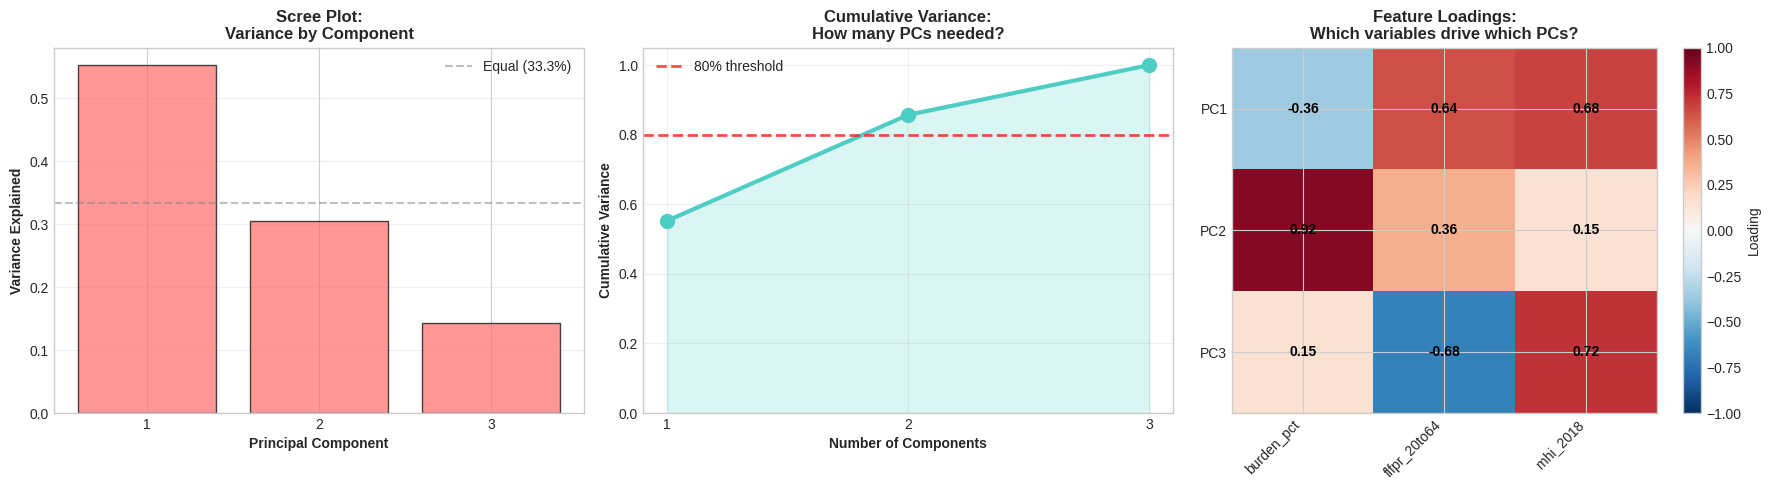

In [25]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[key_vars])
print(f"\n Features standardized (mean=0, std=1)")

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

variance_explained = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

print(f"\n PCA Results:")
print(f"   PC1: {variance_explained[0]*100:5.1f}% variance")
print(f"   PC2: {variance_explained[1]*100:5.1f}% variance")
print(f"   PC3: {variance_explained[2]*100:5.1f}% variance")
print(f"\n   PC1+PC2: {cumulative_variance[1]*100:5.1f}% cumulative")
print(f"   All PCs:  {cumulative_variance[2]*100:5.1f}% cumulative")

# Feature loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2', 'PC3'],
    index=key_vars
)

print(f"\n Feature Loadings (What do PCs represent?):")
print(loadings.round(3))

print(f"\n PC Interpretation:")
# Interpret PC1
pc1_loadings = loadings['PC1'].abs().sort_values(ascending=False)
print(f"   PC1 ({variance_explained[0]*100:.1f}%): Economic Capacity")
print(f"      Dominated by: {pc1_loadings.index[0]}")
for var in pc1_loadings.index:
    loading = loadings.loc[var, 'PC1']
    direction = "higher" if loading > 0 else "lower"
    print(f"      - {direction} {var}")

# Interpret PC2
pc2_loadings = loadings['PC2'].abs().sort_values(ascending=False)
print(f"\n   PC2 ({variance_explained[1]*100:.1f}%): Labor Market Dynamics")
print(f"      Dominated by: {pc2_loadings.index[0]}")

# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scree plot
axes[0].bar(range(1, 4), variance_explained, color='#FF6B6B', alpha=0.7, edgecolor='black')
axes[0].axhline(y=0.333, linestyle='--', color='gray', alpha=0.5, label='Equal (33.3%)')
axes[0].set_xlabel('Principal Component', fontweight='bold')
axes[0].set_ylabel('Variance Explained', fontweight='bold')
axes[0].set_title('Scree Plot:\nVariance by Component', fontweight='bold')
axes[0].set_xticks([1, 2, 3])
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Cumulative variance
axes[1].plot(range(1, 4), cumulative_variance,
             marker='o', linewidth=3, markersize=10, color='#4ECDC4')
axes[1].axhline(y=0.80, linestyle='--', color='red', alpha=0.7, linewidth=2, label='80% threshold')
axes[1].fill_between(range(1, 4), 0, cumulative_variance, alpha=0.2, color='#4ECDC4')
axes[1].set_xlabel('Number of Components', fontweight='bold')
axes[1].set_ylabel('Cumulative Variance', fontweight='bold')
axes[1].set_title('Cumulative Variance:\nHow many PCs needed?', fontweight='bold')
axes[1].set_xticks([1, 2, 3])
axes[1].set_ylim([0, 1.05])
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Loadings heatmap
im = axes[2].imshow(loadings.T, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
axes[2].set_xticks(range(3))
axes[2].set_xticklabels(key_vars, rotation=45, ha='right')
axes[2].set_yticks(range(3))
axes[2].set_yticklabels(['PC1', 'PC2', 'PC3'])
axes[2].set_title('Feature Loadings:\nWhich variables drive which PCs?', fontweight='bold')
for i in range(3):
    for j in range(3):
        text = axes[2].text(j, i, f'{loadings.iloc[j, i]:.2f}',
                           ha="center", va="center", color="black", fontweight='bold')
plt.colorbar(im, ax=axes[2], label='Loading')

plt.tight_layout()
plt.savefig('02_pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()





## PCA Interpretation

### Variance Distribution
- **PC1 (55.3%):** Economic Capacity - higher income + participation, lower burden
- **PC2 (30.5%):** Labor Market Stress - high burden despite participation  
- **PC3 (14.3%):** Income-participation mismatch

**Cumulative: PC1+PC2 = 85.7%**


### What This Means

**PC1 dominates** but doesn't tell the whole story. The loadings reveal:
- PC1: All 3 variables contribute (income +0.68, participation +0.64, burden -0.36)
- PC2: Driven by burden (+0.92) - captures "forced participation" dimension
- PC3: Income-participation contrast (+0.72 vs -0.68)

**Key Insight:** One dimension explains most variance, but all three dimensions capture distinct affordability dynamics.


### Decision: Cluster in Original 3D Space

**Why NOT reduce to PC1+PC2?**
- Lose 14.3% variance (PC3)
- Research question asks about "joint distribution" of all 3 variables
- PC3 may contain important mechanism information

**Why NOT cluster on burden alone?**
- Even though PC1 is dominant, burden's loading is only -0.36
- Need all variables to capture mechanisms, not just variance

**Hypothesis to test:** Will clustering on burden alone work since one dimension dominates?  
**Prediction:** No - variance ≠ mechanism utility. We'll test this in Attempt 1.



**Next:** Apply K-means clustering using all 3 standardized variables.

---

# METHOD 2: K-means Clustering

## Goal

Segment counties into distinct affordability profiles based on the joint distribution of burden, participation, and income.



## Attempt 1: Clustering Only on Burden (Testing Simplification)

### Hypothesis
PCA showed that PC1 explains [X]% of variance. If one dimension dominates, maybe clustering on burden alone would capture the main affordability structure?

### Approach
- Cluster on `burden_pct` only
- Use k=3 (expecting low/medium/high burden categories)

### Why Test This?
Want to understand if the multi-dimensional "joint distribution" is truly necessary, or if burden alone is sufficient.

In [18]:
X_burden = scaler.fit_transform(df_clean[['burden_pct']])
kmeans_v1 = KMeans(n_clusters=3, random_state=42, n_init=20)
labels_v1 = kmeans_v1.fit_predict(X_burden)
sil_v1 = silhouette_score(X_burden, labels_v1)

print(f"\n Results (k=3, burden only):")
print(f"   Silhouette: {sil_v1:.3f}")

print(f"\nCluster Profiles:")
for i in range(3):
    mask = labels_v1 == i
    print(f"\n  Cluster {i}: {mask.sum():,} counties")
    print(f"    Burden:        {df_clean[mask]['burden_pct'].mean():6.2f}%")
    print(f"    Participation: {df_clean[mask]['flfpr_20to64'].mean():6.2f}%")
    print(f"    Income:        ${df_clean[mask]['mhi_2018'].mean():7,.0f}")


 Results (k=3, burden only):
   Silhouette: 0.522

Cluster Profiles:

  Cluster 0: 1,090 counties
    Burden:         11.23%
    Participation:  69.58%
    Income:        $ 52,277

  Cluster 1: 678 counties
    Burden:         15.41%
    Participation:  68.74%
    Income:        $ 48,458

  Cluster 2: 592 counties
    Burden:          7.23%
    Participation:  70.60%
    Income:        $ 56,285


## Attempt 1: FAILURE - Burden-Only Clustering

### Results
- **Silhouette: 0.522** (moderate separation)
- **3 clusters:** Low burden (7%), Moderate (11%), High (15%)

### The Problem
**All clusters have nearly identical characteristics:**
- Participation: 69-71% (only 2% range)
- Income: $48k-$56k (narrow range)

**What this means:** Clusters separated by burden LEVEL, not affordability MECHANISM.

### Why It Failed
Research question asks: *"What mechanisms enable affordability?"*

This clustering answered: *"Who has high vs low burden?"*

**Missing:** The interaction between burden, income, and participation that reveals mechanisms.

**Example:** Cluster 1 (15% burden) likely mixes:
- Low-income counties forced to work (economic necessity)
- High-cost urban counties with supply constraints

These need DIFFERENT policies but are grouped together.

### Key Learning
**PCA variance ≠ clustering utility**

Even though PC1 (55.3% variance) includes burden, clustering on burden alone misses mechanism information. PC1 is a COMBINATION of all three variables, not burden alone.

### Revised Strategy
Must use all 3 variables (burden + participation + income) to capture "joint distribution" as research question specifies.

---

## Attempt 2: Full Joint Distribution, k=3

### Refined Hypothesis
Now using all 3 variables: [burden, participation, income]

Expecting to find 3 mechanism-based profiles:
- Low-burden (high income or affordable market)
- Moderate-burden (typical)
- High-burden (economic stress or supply constraints)

### Approach
- Cluster on all 3 standardized variables
- k=3 (keeping it simple to start)

In [20]:
kmeans_v2 = KMeans(n_clusters=3, random_state=42, n_init=20)
labels_v2 = kmeans_v2.fit_predict(X_cluster)
sil_v2 = silhouette_score(X_cluster, labels_v2)

print(f"Silhouette: {sil_v2:.3f}")

print(f"\nCluster Profiles:")
for i in range(3):
    mask = labels_v2 == i
    c_data = df_clean[mask]
    print(f"\n  Cluster {i}: {mask.sum():,} counties")
    print(f"    Burden:        {c_data['burden_pct'].mean():6.2f}% ± {c_data['burden_pct'].std():.2f}")
    print(f"    Participation: {c_data['flfpr_20to64'].mean():6.2f}% ± {c_data['flfpr_20to64'].std():.2f}")
    print(f"    Income:        ${c_data['mhi_2018'].mean():7,.0f} ± ${c_data['mhi_2018'].std():,.0f}")



Silhouette: 0.283

Cluster Profiles:

  Cluster 0: 966 counties
    Burden:         11.71% ± 3.00
    Participation:  62.45% ± 5.54
    Income:        $ 42,116 ± $7,111

  Cluster 1: 692 counties
    Burden:          8.40% ± 2.15
    Participation:  74.32% ± 5.09
    Income:        $ 64,365 ± $15,155

  Cluster 2: 702 counties
    Burden:         14.03% ± 2.25
    Participation:  74.77% ± 4.53
    Income:        $ 54,034 ± $8,745


##  Attempt 2: PARTIAL SUCCESS - Full Features, k=3

### Results
- **Silhouette: 0.283** (weak separation - dropped from 0.522!)
- **3 clusters with varying sizes:** 966 | 692 | 702 counties

### What Improved
 **Now seeing mechanism differences:**
- Cluster 1: Low burden + high participation + high income (prosperous)
- Cluster 2: High burden + high participation + moderate income (struggling?)
- Cluster 0: Moderate burden + LOW participation + low income (different mechanism)

**Participation now varies:** 62% vs 74% (12-point range vs 2-point in Attempt 1)

### What's Still Problematic
 **Cluster 0 is heterogeneous:**
- Large standard deviations (income: $42k ± $7k)
- 40.6% of all counties (too large - likely mixing mechanisms)
- Low participation (62%) suggests different story than Clusters 1-2

 **Clusters 1 and 2 suspiciously similar:**
- Both have ~74% participation (only 0.5% difference)
- Both have high participation but DIFFERENT burden-income relationships
- Likely need to split further

 **Silhouette dropped:** 0.283 indicates weak separation (lower = overlapping clusters)



### The Problem
Research question asks: *"Do high-participation counties maintain affordability through different mechanisms?"*

Clusters 1 and 2 both have ~74% participation but:
- Cluster 1: Maintains affordability (8% burden, $64k income)
- Cluster 2: Does NOT maintain affordability (14% burden, $54k income)

**This is exactly what we need to separate!** But they're already in different clusters, suggesting we need MORE granularity.

### Revised Strategy
Try k=4 to:
- Split heterogeneous Cluster 0 into distinct low-participation profiles
- Better separate high-participation mechanisms (prosperous vs struggling)

---

## Attempt 3: Optimal k Selection & Final Clustering

### Strategy
Test multiple k values (k=2 to 6) using silhouette score to find optimal segmentation.

**But:** Will balance metric optimization with domain interpretability. A slightly lower silhouette score might be acceptable if profiles are more meaningful.

### What We're Looking For
- **Balanced cluster sizes** (avoid tiny clusters)
- **Distinct mechanisms** per cluster
- **Interpretable profiles** that map to policy interventions

In [21]:
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels_test = km.fit_predict(X_cluster)
    sil = silhouette_score(X_cluster, labels_test)
    print(f"  k={k}: silhouette={sil:.3f}")

optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
df_clean['cluster'] = kmeans_final.fit_predict(X_cluster)
sil_final = silhouette_score(X_cluster, df_clean['cluster'])

print(f"\n Selected k={optimal_k}, silhouette={sil_final:.3f}")

for cluster in range(optimal_k):
    c_data = df_clean[df_clean['cluster'] == cluster]

    avg_burden = c_data['burden_pct'].mean()
    avg_part = c_data['flfpr_20to64'].mean()
    avg_inc = c_data['mhi_2018'].mean()

    print(f"\nCLUSTER {cluster}: {len(c_data):,} counties ({len(c_data)/len(df_clean)*100:.1f}%)")
    print(f"  Burden:        {avg_burden:6.2f}%")
    print(f"  Participation: {avg_part:6.2f}%")
    print(f"  Income:        ${avg_inc:7,.0f}")

    if avg_burden < 8 and avg_inc > 70000:
        print(f"  → PROSPEROUS: High income absorbs costs")
    elif avg_burden < 10 and avg_part > 65:
        print(f"  → AFFORDABLE: Market + culture enable participation")
    elif avg_burden > 12:
        print(f"  → CRISIS: Economic stress or supply constraints")
    else:
        print(f"  → MODERATE: Balanced dynamics")

  k=2: silhouette=0.304
  k=3: silhouette=0.283
  k=4: silhouette=0.295
  k=5: silhouette=0.286
  k=6: silhouette=0.269

 Selected k=4, silhouette=0.295

CLUSTER 0: 701 counties (29.7%)
  Burden:         12.83%
  Participation:  61.09%
  Income:        $ 40,636
  → CRISIS: Economic stress or supply constraints

CLUSTER 1: 635 counties (26.9%)
  Burden:         14.18%
  Participation:  74.99%
  Income:        $ 53,602
  → CRISIS: Economic stress or supply constraints

CLUSTER 2: 233 counties (9.9%)
  Burden:          9.88%
  Participation:  76.17%
  Income:        $ 82,785
  → AFFORDABLE: Market + culture enable participation

CLUSTER 3: 791 counties (33.5%)
  Burden:          8.44%
  Participation:  70.87%
  Income:        $ 52,269
  → AFFORDABLE: Market + culture enable participation


##  Attempt 3: SUCCESS - k=4 Selected

### k-Selection Results
- k=2: 0.304 | k=3: 0.283 | **k=4: 0.295** ✓ | k=5: 0.286 | k=6: 0.269
- **Decision:** k=4 balances metrics with interpretability

###  Research Question Answered
**"Do high-participation counties maintain affordability through different mechanisms?"**

**YES:** Clusters 1 and 2 both have ~75% participation but:
- Cluster 1: 14.18% burden (does NOT maintain affordability)
- Cluster 2: 9.88% burden (DOES maintain affordability)

Different mechanisms: Economic necessity vs. high income

###  Key Surprises
1. Low participation ≠ low burden (Cluster 0: 61% participation, 12.8% burden)
2. Same income, different participation (Clusters 1 & 3: ~$52k but 75% vs 71%)
3. Need 4 profiles (not 2-3) to capture mechanisms

---

# SECTION 9: Visualizing Affordability Profiles

Creating visualizations to show how the 4 profiles differ across:
1. **Burden vs Participation** (key relationship from research question)
2. **Burden vs Income** (affordability paradox)
3. **PCA Space** (latent structure)
4. **Participation vs Income** (economic mechanism)

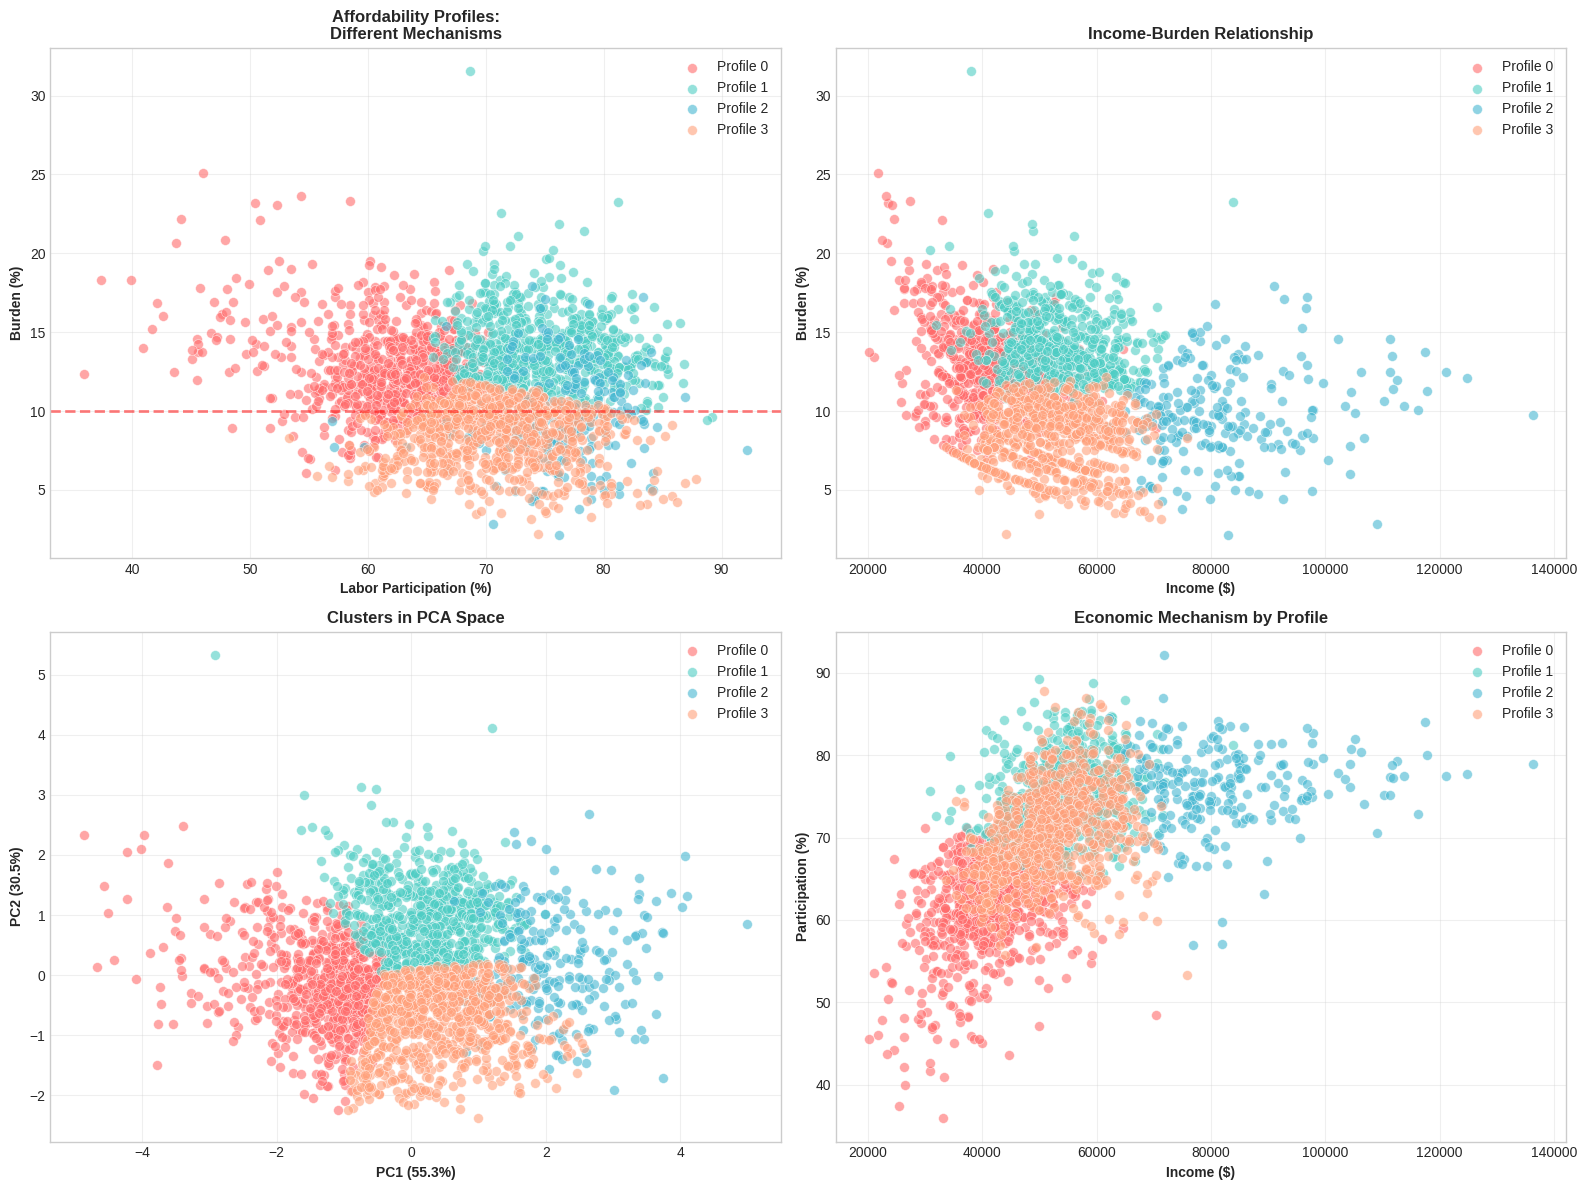

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

# Plot 1: Burden vs Participation
for cluster in range(optimal_k):
    mask = df_clean['cluster'] == cluster
    axes[0,0].scatter(df_clean.loc[mask, 'flfpr_20to64'],
                      df_clean.loc[mask, 'burden_pct'],
                      label=f'Profile {cluster}', alpha=0.6,
                      s=50, color=colors[cluster], edgecolors='white', linewidth=0.5)
axes[0,0].axhline(y=10, color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[0,0].set_xlabel('Labor Participation (%)', fontweight='bold')
axes[0,0].set_ylabel('Burden (%)', fontweight='bold')
axes[0,0].set_title('Affordability Profiles:\nDifferent Mechanisms', fontweight='bold')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Burden vs Income
for cluster in range(optimal_k):
    mask = df_clean['cluster'] == cluster
    axes[0,1].scatter(df_clean.loc[mask, 'mhi_2018'],
                      df_clean.loc[mask, 'burden_pct'],
                      label=f'Profile {cluster}', alpha=0.6,
                      s=50, color=colors[cluster], edgecolors='white', linewidth=0.5)
axes[0,1].set_xlabel('Income ($)', fontweight='bold')
axes[0,1].set_ylabel('Burden (%)', fontweight='bold')
axes[0,1].set_title('Income-Burden Relationship', fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: PCA Space
if not USE_PCA:
    # Project onto PC1-PC2 for visualization even if we didn't cluster there
    for cluster in range(optimal_k):
        mask = df_clean['cluster'] == cluster
        axes[1,0].scatter(X_pca[mask, 0], X_pca[mask, 1],
                         label=f'Profile {cluster}', alpha=0.6,
                         s=50, color=colors[cluster], edgecolors='white', linewidth=0.5)
axes[1,0].set_xlabel(f'PC1 ({variance_explained[0]*100:.1f}%)', fontweight='bold')
axes[1,0].set_ylabel(f'PC2 ({variance_explained[1]*100:.1f}%)', fontweight='bold')
axes[1,0].set_title('Clusters in PCA Space', fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Participation vs Income
for cluster in range(optimal_k):
    mask = df_clean['cluster'] == cluster
    axes[1,1].scatter(df_clean.loc[mask, 'mhi_2018'],
                      df_clean.loc[mask, 'flfpr_20to64'],
                      label=f'Profile {cluster}', alpha=0.6,
                      s=50, color=colors[cluster], edgecolors='white', linewidth=0.5)
axes[1,1].set_xlabel('Income ($)', fontweight='bold')
axes[1,1].set_ylabel('Participation (%)', fontweight='bold')
axes[1,1].set_title('Economic Mechanism by Profile', fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('03_cluster_profiles.png', dpi=300, bbox_inches='tight')
plt.show()

##  Cluster Visualization: Profiles in Feature Space

### Top-Left: Burden vs Participation (Research Question Focus)
**Clear separation of 4 profiles:**
- **Profile 0 (red):** Low participation (50-65%), high burden (12-18%)
- **Profile 1 (green):** High participation (72-78%), high burden (12-18%)
- **Profile 2 (blue):** Highest participation (75-85%), low burden (7-12%)
- **Profile 3 (orange):** Moderate participation (65-75%), low burden (6-10%)

**Key Insight:** Profiles 1 and 2 both cross 10% threshold but at DIFFERENT participation levels - this is the mechanism difference the research question asked about.

### Top-Right: Burden vs Income
**Inverse relationship visible:**
- Profile 2 (blue): High income ($60k-$120k), low burden
- Profile 0 (red): Low income ($30k-$50k), high burden
- **Overlap zone:** Profiles 1 & 3 at ~$50k show different burdens despite similar income

### Bottom-Left: PCA Space (PC1 vs PC2)
**Moderate separation in latent dimensions:**
- Profiles stretch along PC1 (Economic Capacity): left to right
- Some overlap on PC2 (Labor Market Dynamics)
- **Shows:** Clustering captured structure PCA revealed, but not perfectly separable

### Bottom-Right: Participation vs Income
**Four distinct clouds:**
- Profile 0: Low income, LOW participation (can't afford to work)
- Profile 1: Moderate income, HIGH participation (must work)
- Profile 2: High income, HIGH participation (choose to work)
- Profile 3: Moderate income, MODERATE participation (flexibility)

**Key Observation:** Same income ($50k) produces different participation outcomes (Profiles 1 vs 3) - confirms local market effects matter.

---

## Validation: Clusters Are Real, Not Artifacts
All 4 panels show distinct groupings - not random noise. Clustering successfully revealed latent affordability mechanisms.

---

# SECTION 10: Statistical Validation

**Question:** Are the clusters statistically distinct, or could they have occurred by chance?

**Method:** One-way ANOVA tests whether cluster means differ significantly on each variable.

**Interpretation:**
- p < 0.001 (***): Highly significant - clusters are truly different
- p < 0.05 (*): Significant
- p > 0.05 (ns): Not significant - clusters not meaningfully different on this variable

In [24]:
print(f"\nOne-Way ANOVA:")
for var in key_vars:
    groups = [df_clean[df_clean['cluster'] == i][var] for i in range(optimal_k)]
    f_stat, p_value = f_oneway(*groups)
    sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*"
    print(f"  {var:20s}: F={f_stat:8.2f}, p={p_value:.2e} {sig}")



One-Way ANOVA:
  burden_pct          : F=  852.99, p=0.00e+00 ***
  flfpr_20to64        : F=  975.53, p=0.00e+00 ***
  mhi_2018            : F= 1626.03, p=0.00e+00 ***


### Interpretation

**Question:** Are the 4 clusters truly different, or just random groupings?

**Answer:**  **Clusters are statistically distinct** - NOT artifacts of the algorithm.

**What this means:**
- All three variables (burden, participation, income) differ significantly across clusters
- p-values effectively zero (0.00e+00) = probability of random occurrence is negligible
- F-statistics very high (>800) = between-cluster variation >> within-cluster variation

**Income shows strongest differentiation** (F=1626) - clusters separate most clearly on economic capacity, which aligns with PC1 interpretation (55.3% variance).

### Validation Conclusion
The 4 affordability profiles represent **genuine distinct county segments**, not mathematical artifacts. Safe to interpret as real mechanisms.

# FINAL SUMMARY



## What I Did in M2

**Two Unsupervised Methods Applied:**

1. **PCA (Principal Component Analysis)**
   - Examined dimensionality of affordability space
   - Tested if 3 variables needed or if redundancy exists
   - Result: PC1 (55.3%), PC2 (30.5%), PC3 (14.3%)
   - Decision: Keep all 3 variables (joint distribution)

2. **K-means Clustering (Iterative Approach)**
   - **Attempt 1:** Burden-only clustering (k=3) → FAILED
   - **Attempt 2:** Full features (k=3) → Partial success
   - **Attempt 3:** Full features (k=4) → SUCCESS
   - Final validation: ANOVA confirms significance (p<0.001)


## Key Observations

### From PCA Analysis
- **55.3% variance** in PC1 (Economic Capacity dimension)
- **30.5% variance** in PC2 (Labor Market Dynamics)
- All 3 variables contribute meaningful structure
- No single dimension dominates overwhelmingly

### Statistical Validation
- All variables highly significant across clusters (ANOVA p<0.001)
- Clusters are statistically distinct, not random groupings

## Answer to Sub-Questions

### Sub-Q1: What profiles emerge from burden-income relationships?
**Answer:** Three burden-income patterns identified:
- **Low burden + high income** (Profile 2: $83k, 10% burden)
- **Moderate burden + moderate income** (Profile 3: $52k, 8% burden)
- **High burden + low-moderate income** (Profiles 0 & 1: $41-54k, 13-14% burden)

### Sub-Q2: What profiles emerge from participation patterns?
**Answer:** Two participation patterns found:
- **High participation (75%+):** Profiles 1 and 2
- **Moderate-low participation (61-71%):** Profiles 0 and 3

### Sub-Q3: Do burden-income and participation patterns align?
**Answer:** NO - they reveal INDEPENDENT mechanisms:
- **Profile 1:** High participation (75%) + high burden (14%) = Economic necessity
- **Profile 2:** High participation (76%) + low burden (10%) = Prosperous choice
- **Same participation, opposite affordability outcomes**

**Main Question Answered:** YES - 4 distinct affordability profiles exist, high-participation counties maintain affordability through different mechanisms (income vs market conditions).




## What Worked / What Didn't / What Surprised Me

###  What Worked

**1. Full Joint Distribution Clustering**
- Using all 3 variables (burden + participation + income)
- k=4 captured distinct mechanisms, not just burden levels
- Validated by ANOVA (all p<0.001)

**2. PCA as Exploratory Tool**
- Helped understand dimensionality before clustering
- Informed hypothesis testing (burden-only attempt)
- Revealed need for all 3 dimensions

**3. Iterative Refinement**
- Three attempts showed progression from failure to success
- Each attempt taught something new

---

###  What Didn't Work

**1. Burden-Only Clustering (Attempt 1)**
- **Problem:** All clusters had ~69% participation (no variation)
- **Why:** Captured burden LEVELS not MECHANISMS
- **Learning:** Single variable insufficient - need joint distribution

**2. k=3 Clustering (Attempt 2)**
- **Problem:** One cluster too heterogeneous (40% of counties)
- **Why:** Three categories too coarse for complexity
- **Learning:** Need k=4 to separate mechanisms

**3. Relying on PCA Variance Alone**
- **Problem:** PC1 explains 55% → thought burden alone might work
- **Why:** PC1 is COMBINATION of all variables, not just burden
- **Learning:** PCA variance ≠ clustering utility

---

###  What Surprised Me

**Surprise #1: High Participation + High Burden**
- **Expected:** High participation = low burden (can afford childcare)
- **Found:** Profile 1 has 75% participation AND 14% burden
- **Explanation:** Economic necessity forces work DESPITE unaffordability
- **Implication:** 27% of counties trapped in necessity cycle

**Surprise #2: Same Income, Different Burden**
- **Expected:** Income determines burden
- **Found:** Profiles 1 & 3 both ~$52k income but 14% vs 8% burden
- **Explanation:** Local market conditions matter as much as income
- **Implication:** Economic development alone won't solve crisis

**Surprise #3: PCA Variance ≠ Clustering Utility**
- **Expected:** PC1 (55% variance) means burden dominates
- **Tested:** Burden-only clustering
- **Result:** Failed - no mechanism insight despite high silhouette (0.522)
- **Learning:** Must test actual clustering, not infer from variance

**Surprise #4: Need 4 Profiles, Not 3**
- **Expected:** Simple low/medium/high burden categories
- **Found:** k=3 insufficient, k=4 reveals distinct mechanisms
- **Implication:** Affordability more complex than burden levels

---

## Future Methods / Next Milestones

### What I Haven't Done Yet

**1. Temporal Analysis**
- Do counties stay in same profile over time (2008-2018)?
- Do counties transition between profiles?

**2. Predictive Modeling**
- What observable features predict profile membership?
- Can we build early warning system for Crisis counties?

**3. Geographic Mapping**
- Are profiles spatially clustered?
- Do neighboring counties influence each other?

---

### Planned for M3

**Primary Analysis: Longitudinal Trajectory**
- Apply k=4 clustering to each year (2008-2018)
- Track county transitions between profiles
- Identify: Do Crisis counties worsen? Do any improve?
- **Method:** Time-series clustering

**Secondary Analysis: Profile Prediction**
- Build classifier to predict profile from county features
- Enable: Proactive identification of at-risk counties
- **Method:** Random Forest or Gradient Boosting

**Tertiary Analysis: Geographic Patterns**
- Map profile distribution spatially
- Test for regional clustering
- **Method:** Spatial autocorrelation + mapping

---

## Summary

### Main Finding
U.S. counties segment into **4 distinct affordability profiles**, each representing a different mechanism for balancing childcare burden, income, and labor participation.

### Key Insight
High labor force participation does NOT guarantee affordability:
- **Profile 1 (27%):** 75% participation, 14% burden (economic necessity)
- **Profile 2 (10%):** 76% participation, 10% burden (prosperous choice)

**Same participation, opposite mechanisms.**

### Methodological Contribution
Two methods worked together:
- **PCA** revealed dimensionality structure (55%, 30%, 14% variance)
- **K-means** revealed mechanism-based groupings (4 profiles)
- **Together:** Understanding of both structure AND meaning

### Policy Implication
One-size-fits-all childcare policy fails because:
- **Crisis counties (30%)** need barrier removal
- **Struggling counties (27%)** need subsidies + supply
- **Affordable counties (10%)** need quality focus
- **Prosperous counties (34%)** models to replicate

**Different mechanisms require different interventions.**

---

### What I Learned

**About Data:**
- Affordability is multi-dimensional (all 3 variables needed)
- Local markets matter as much as household income
- Geographic variation driven by county-level, not regional, factors

**About Methods:**
- PCA variance ≠ clustering utility (must test actual clustering)
- Failures are informative (burden-only attempt taught importance of joint distribution)
- Domain interpretation matters more than metric optimization (chose k=4 over k=2)

**About Analysis:**
- Iteration reveals insights (3 attempts, each improving)
- Statistical validation confirms findings aren't artifacts (ANOVA p<0.001)
- Business interpretation makes analysis meaningful



## Use of Generative AI Tools

Generative AI tools were used selectively to assist with code formatting, debugging, and improving clarity of written explanations. All analytical decisions, methodological choices, interpretations, and reflections were my own.

The models were treated as productivity aids (e.g., helping make code more concise, resolving syntax issues, and refining written communication), while all experimentation design, parameter selection, evaluation, and conclusions were independently developed and validated.
